-------

<h1 align='center'>Customer Lifetime Value</h1>

-----

In [1]:
#Importing Libraries
import pandas as pd
import sqldf
import matplotlib.pyplot as plt
import warnings
import datetime
warnings.filterwarnings('ignore')

In [2]:
#Reading Data
data = pd.read_csv('rfm_data.txt',sep='\t',header=None,names=['customer_id', 'purchase_amount', 'date_of_purchase'])

data.head(4)

,customer_id,purchase_amount,date_of_purchase
0,760,25.0,2009-11-06
1,860,50.0,2012-09-28
2,1200,100.0,2005-10-25
3,1420,50.0,2009-07-09


In [3]:
#Converting to datetime
data['date_of_purchase'] = pd.to_datetime(data['date_of_purchase'])

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51243 entries, 0 to 51242
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customer_id       51243 non-null  int64         
 1   purchase_amount   51243 non-null  float64       
 2   date_of_purchase  51243 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 1.2 MB


In [5]:
data.head(4)

,customer_id,purchase_amount,date_of_purchase
0,760,25.0,2009-11-06
1,860,50.0,2012-09-28
2,1200,100.0,2005-10-25
3,1420,50.0,2009-07-09


In [6]:
#Fetch Year from date_of_purchase
data['year_of_purchase'] = data['date_of_purchase'].dt.year

In [7]:
data.head(4)

,customer_id,purchase_amount,date_of_purchase,year_of_purchase
0,760,25.0,2009-11-06,2009
1,860,50.0,2012-09-28,2012
2,1200,100.0,2005-10-25,2005
3,1420,50.0,2009-07-09,2009


In [8]:
#Difference btw the date_of_purchase and 2016-01-01
data['days_since'] = ((datetime.datetime(2016,1,1)-data['date_of_purchase']))
data['days_since'] = data['days_since'].astype('str').str.split(" ",expand=True)
data['days_since'] = data['days_since'].astype('int64')
data.head(4)

,customer_id,purchase_amount,date_of_purchase,year_of_purchase,days_since
0,760,25.0,2009-11-06,2009,2247
1,860,50.0,2012-09-28,2012,1190
2,1200,100.0,2005-10-25,2005,3720
3,1420,50.0,2009-07-09,2009,2367


In [9]:
#RFM for 2015
customers_2015 = sqldf.run('''SELECT customer_id,
                               MIN(days_since) AS 'recency',
                               MAX(days_since) AS 'first_purchase',
                               COUNT(*) AS 'frequency',
                               AVG(purchase_amount) AS 'amount'
                        FROM data GROUP BY 1''')

In [10]:
customers_2015.head(4)

,customer_id,recency,first_purchase,frequency,amount
0,10,3829,3829,1,30.000000
1,80,343,3751,7,71.428571
2,90,758,3783,10,115.800000
3,120,1401,1401,1,20.000000


In [11]:
#Customer Segmentation
customers_2015['segment'] = np.nan

customers_2015.segment.iloc[(customers_2015.recency > 365*3),] = "inactive"

customers_2015.segment.iloc[((customers_2015.recency <= 365*3) & (customers_2015.recency > 365*2)),] = "cold"

customers_2015.segment.iloc[((customers_2015.recency <= 365*2) & (customers_2015.recency > 365*1)),] = "warm"
customers_2015.segment.iloc[(customers_2015.recency <= 365),] = "active"
customers_2015.segment.iloc[((customers_2015.segment == "warm") & (customers_2015.first_purchase <= 365*2)),] = "new warm"
customers_2015.segment.iloc[((customers_2015.segment == "warm") & (customers_2015.amount < 100)),] = "warm low value"
customers_2015.segment.iloc[((customers_2015.segment == "warm") & (customers_2015.amount >= 100)),] = "warm high value"
customers_2015.segment.iloc[((customers_2015.segment == "active") & (customers_2015.first_purchase <= 365)),] = "new active"
customers_2015.segment.iloc[((customers_2015.segment == "active") & (customers_2015.amount < 100)),] = "active low value"
customers_2015.segment.iloc[((customers_2015.segment == "active") & (customers_2015.amount >= 100)),] = "active high value"

In [12]:
#Segments
customers_2015.segment = pd.Categorical(customers_2015.segment,categories=["inactive", "cold",
               "warm high value", 
               "warm low value", 
               "new warm",
               "active high value", 
               "active low value", 
               "new active"])

In [13]:
#RFM for 2014
customers_2014 = sqldf.run('''SELECT customer_id,
                               MIN(days_since) - 365 AS 'recency',
                               MAX(days_since) - 365 AS 'first_purchase',
                               COUNT(*) AS 'frequency',
                               AVG(purchase_amount) AS 'amount'
                        FROM data
                        WHERE days_since > 365
                        GROUP BY 1''')

In [14]:
customers_2014.head(4)

,customer_id,recency,first_purchase,frequency,amount
0,10,3464,3464,1,30.0
1,80,302,3386,6,70.0
2,90,393,3418,10,115.8
3,120,1036,1036,1,20.0


In [15]:
#Customer Segmentation
customers_2014['segment'] = np.nan

customers_2014.segment.iloc[(customers_2014.recency > 365*3),] = "inactive"

customers_2014.segment.iloc[((customers_2014.recency <= 365*3) & (customers_2014.recency > 365*2)),] = "cold"

customers_2014.segment.iloc[((customers_2014.recency <= 365*2) & (customers_2014.recency > 365*1)),] = "warm"
customers_2014.segment.iloc[(customers_2014.recency <= 365),] = "active"
customers_2014.segment.iloc[((customers_2014.segment == "warm") & (customers_2014.first_purchase <= 365*2)),] = "new warm"
customers_2014.segment.iloc[((customers_2014.segment == "warm") & (customers_2014.amount < 100)),] = "warm low value"
customers_2014.segment.iloc[((customers_2014.segment == "warm") & (customers_2014.amount >= 100)),] = "warm high value"
customers_2014.segment.iloc[((customers_2014.segment == "active") & (customers_2014.first_purchase <= 365)),] = "new active"
customers_2014.segment.iloc[((customers_2014.segment == "active") & (customers_2014.amount < 100)),] = "active low value"
customers_2014.segment.iloc[((customers_2014.segment == "active") & (customers_2014.amount >= 100)),] = "active high value"

In [16]:
#Segments
customers_2014.segment = pd.Categorical(customers_2014.segment,categories=["inactive", "cold",
               "warm high value", 
               "warm low value", 
               "new warm",
               "active high value", 
               "active low value", 
               "new active"])

In [17]:
customers_2014.head(4)

,customer_id,recency,first_purchase,frequency,amount,segment
0,10,3464,3464,1,30.0,inactive
1,80,302,3386,6,70.0,active low value
2,90,393,3418,10,115.8,warm high value
3,120,1036,1036,1,20.0,cold


In [18]:
#Merging both the segments
new_data = pd.merge(customers_2014,customers_2015,on='customer_id')

In [19]:
#After merging
new_data

,customer_id,recency_x,first_purchase_x,frequency_x,amount_x,segment_x,recency_y,first_purchase_y,frequency_y,amount_y,segment_y
0,10,3464,3464,1,30.0,inactive,3829,3829,1,30.000000,inactive
1,80,302,3386,6,70.0,active low value,343,3751,7,71.428571,active low value
2,90,393,3418,10,115.8,warm high value,758,3783,10,115.800000,cold
3,120,1036,1036,1,20.0,cold,1401,1401,1,20.000000,inactive
4,130,2605,3345,2,50.0,inactive,2970,3710,2,50.000000,inactive
...,...,...,...,...,...,...,...,...,...,...,...
16900,235200,21,21,1,100.0,new active,386,386,1,100.000000,new warm
16901,235210,89,89,1,500.0,new active,454,454,1,500.000000,new warm
16902,236310,6,6,1,30.0,new active,371,371,1,30.000000,new warm
16903,236660,390,684,2,75.0,new warm,281,1049,3,83.333333,active low value


In [20]:
customers_2014.segment

0                inactive
1        active low value
2         warm high value
3                    cold
4                inactive
               ...       
16900          new active
16901          new active
16902          new active
16903            new warm
16904          new active
Name: segment, Length: 16905, dtype: category
Categories (8, object): ['inactive', 'cold', 'warm high value', 'warm low value', 'new warm', 'active high value', 'active low value', 'new active']

In [21]:
customers_2015.segment

0                inactive
1        active low value
2                    cold
3                inactive
4                inactive
               ...       
18412          new active
18413          new active
18414          new active
18415          new active
18416          new active
Name: segment, Length: 18417, dtype: category
Categories (8, object): ['inactive', 'cold', 'warm high value', 'warm low value', 'new warm', 'active high value', 'active low value', 'new active']

In [22]:
#Transition matrix
transition = pd.crosstab(new_data.segment_x,new_data.segment_y,dropna=False)
transition

segment_y,inactive,cold,warm high value,warm low value,new warm,active high value,active low value,new active
segment_x,,,,,,,,
inactive,7227,0,0,0,0,35,250,0
cold,1931,0,0,0,0,22,200,0
warm high value,0,75,0,0,0,35,1,0
warm low value,0,689,0,0,0,1,266,0
new warm,0,1139,0,0,0,15,96,0
active high value,0,0,119,0,0,354,2,0
active low value,0,0,0,901,0,22,2088,0
new active,0,0,0,0,938,89,410,0


In [23]:
#Dividing each row by its sum
for i in range(len(transition)):
    transition.iloc[i,:] = transition.iloc[i,:]/np.sum(transition.iloc[i,:])

transition

segment_y,inactive,cold,warm high value,warm low value,new warm,active high value,active low value,new active
segment_x,,,,,,,,
inactive,0.962061,0.000000,0.000000,0.000000,0.000000,0.004659,0.033280,0.0
cold,0.896888,0.000000,0.000000,0.000000,0.000000,0.010218,0.092894,0.0
warm high value,0.000000,0.675676,0.000000,0.000000,0.000000,0.315315,0.009009,0.0
warm low value,0.000000,0.720711,0.000000,0.000000,0.000000,0.001046,0.278243,0.0
new warm,0.000000,0.911200,0.000000,0.000000,0.000000,0.012000,0.076800,0.0
active high value,0.000000,0.000000,0.250526,0.000000,0.000000,0.745263,0.004211,0.0
active low value,0.000000,0.000000,0.000000,0.299236,0.000000,0.007307,0.693457,0.0
new active,0.000000,0.000000,0.000000,0.000000,0.652749,0.061935,0.285317,0.0


In [24]:
#Empty Dataframe for storing data from year 2015 to 2025
segments = pd.DataFrame(columns = range(2015,2026), 
                   index = transition.columns)

In [25]:
#First col with 2015 values
segments[2015] = np.asarray(customers_2015.segment.value_counts(sort=False))
segments

,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
segment_y,,,,,,,,,,,
inactive,9158,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cold,1903,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
warm high value,119,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
warm low value,901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
new warm,938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
active high value,573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
active low value,3313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
new active,1512,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
#Predicting value for every year using the trasition proportion
for i in range(2016,2026):
    segments[i] = (np.matmul(segments[i-1],transition))

segments

,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
segment_y,,,,,,,,,,,
inactive,9158,10517.329901,11539.403716,12636.002792,12940.373701,13185.724028,13386.392734,13542.142735,13663.959483,13759.321598,13833.990208
cold,1903,1584.471884,1710.799825,873.879368,820.948611,781.508681,739.914332,708.668285,684.325234,665.286590,650.414823
warm high value,119,143.551579,164.526378,159.988429,156.406974,152.184561,148.632329,145.577932,142.949159,140.695942,138.769335
warm low value,901,991.369313,1058.277981,989.089978,937.724018,883.969667,843.945472,813.032581,789.080625,770.558197,756.237477
new warm,938,986.956159,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
active high value,573,656.722938,638.609277,624.313553,607.459383,593.280303,581.088384,570.595381,561.601447,553.911210,547.350208
active low value,3313,3536.598226,3305.382822,3133.725880,2954.087312,2820.332759,2717.026750,2636.983086,2575.084053,2527.226464,2490.237949
new active,1512,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


#### Plot inactive,cold and active high value customers over time

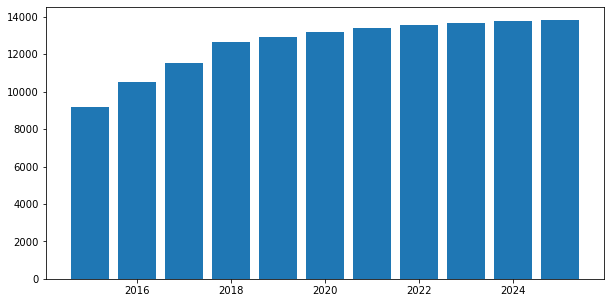

In [27]:
figure = plt.figure(figsize=(10,5))
plt.bar(x=range(2015,2026),height=segments.loc['inactive',:])
plt.show()

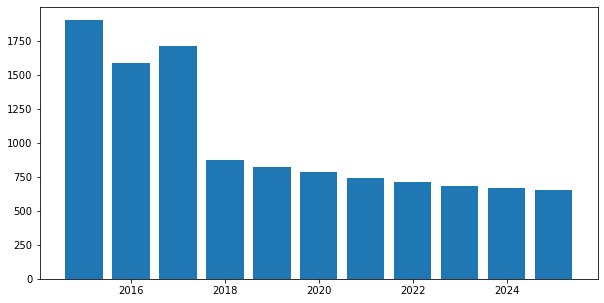

In [28]:
figure = plt.figure(figsize=(10,5))
plt.bar(x=range(2015,2026),height=segments.loc['cold',:])
plt.show()

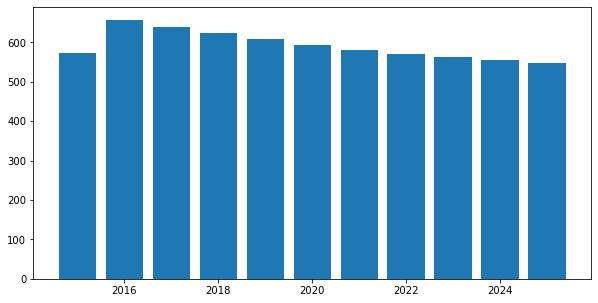

In [29]:
figure = plt.figure(figsize=(10,5))
plt.bar(x=range(2015,2026),height=segments.loc['active high value',:])
plt.show()

In [30]:
# Yearly revenue per segment
# This comes directly from module 2 where the revenue for 2015 customers generated in 2015 is calculated
yearly_revenue = np.asarray([0,0,0,0,0,323.57,52.31,79.17])

yearly_revenue.reshape(8,1)

array([[  0.  ],
       [  0.  ],
       [  0.  ],
       [  0.  ],
       [  0.  ],
       [323.57],
       [ 52.31],
       [ 79.17]])

In [31]:
#revenue per segment
revenue_per_segment = pd.DataFrame(columns = range(2015,2026), 
                   index = transition.columns)

In [32]:
for i in range(2015,2026):
    revenue_per_segment[i] = ((yearly_revenue*segments[i]))

In [33]:
revenue_per_segment

,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
segment_y,,,,,,,,,,,
inactive,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
cold,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
warm high value,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
warm low value,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
new warm,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
active high value,185405.61,212495.841136,206634.803833,202009.136275,196555.632651,191967.707739,188022.768499,184627.547507,181717.380310,179229.050345,177106.106654
active low value,173303.03,184999.453222,172904.575412,163925.200794,154528.307306,147531.606604,142127.669271,137940.585254,134702.646802,132199.216306,130264.347120
new active,119705.04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [34]:
#year-wise revenue generated
yearly_revenue = np.sum(revenue_per_segment,axis=0)
print((yearly_revenue).astype('int64'))

2015    478413
2016    397495
2017    379539
2018    365934
2019    351083
2020    339499
2021    330150
2022    322568
2023    316420
2024    311428
2025    307370
dtype: int64


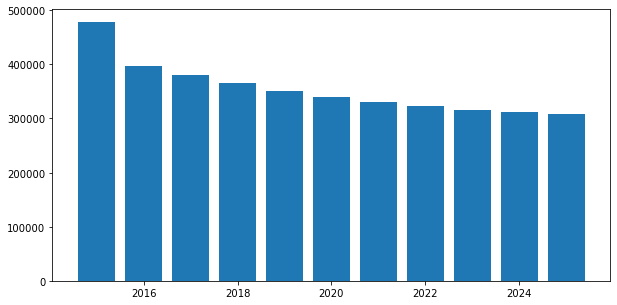

In [35]:
#plot for yearly revenue
figure = plt.figure(figsize=(10,5))
plt.bar(x=range(2015,2026),height=yearly_revenue)
plt.show()

In [36]:
#Cummulative revenue from yearly revenue
cumulated_revenue = np.cumsum(yearly_revenue)
print(cumulated_revenue.astype('int64'))

2015     478413
2016     875908
2017    1255448
2018    1621382
2019    1972466
2020    2311965
2021    2642116
2022    2964684
2023    3281104
2024    3592532
2025    3899903
dtype: int64


In [37]:
#Discount factor
discount_rate = 0.10
discount = np.asarray([1 / ((1 + discount_rate) ** (i - 1)) for i in range(1,12)])
print(discount)

[1.         0.90909091 0.82644628 0.7513148  0.68301346 0.62092132
 0.56447393 0.51315812 0.46650738 0.42409762 0.38554329]


In [38]:
#discounted yearly revenue
disc_yearly_revenue = yearly_revenue * discount
print((disc_yearly_revenue).astype('int64'))

2015    478413
2016    361359
2017    313668
2018    274931
2019    239795
2020    210802
2021    186361
2022    165528
2023    147612
2024    132075
2025    118504
dtype: int64


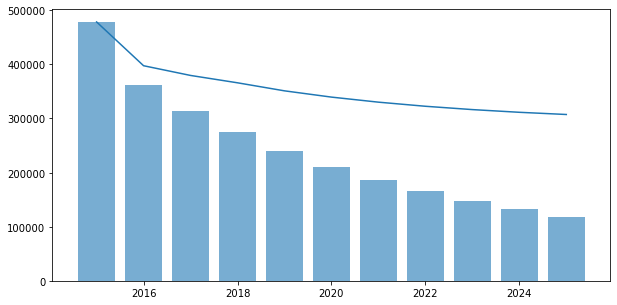

In [39]:
#plot for discounted yearly revenue and yearly revenue
figure = plt.figure(figsize=(10,5))
plt.bar(x=range(2015,2026),height=disc_yearly_revenue,alpha=0.6)
plt.plot(range(2015,2026),yearly_revenue)
plt.show()

In [40]:
#Discounted cummulative yearly revenue
disc_cumulated_revenue = np.cumsum(disc_yearly_revenue)
print((disc_cumulated_revenue).astype('int64'))

2015     478413
2016     839773
2017    1153441
2018    1428373
2019    1668168
2020    1878971
2021    2065332
2022    2230861
2023    2378473
2024    2510549
2025    2629053
dtype: int64


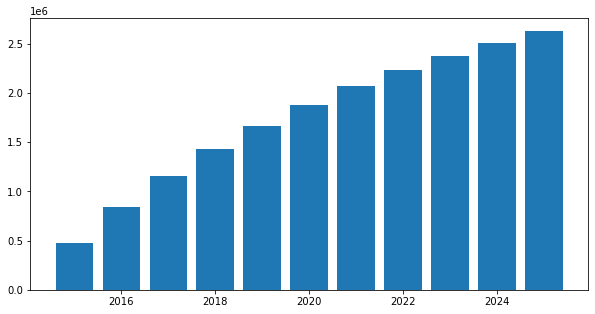

In [41]:
#Plot for Discounted cummulative yearly revenue
figure = plt.figure(figsize=(10,5))
plt.bar(x=range(2015,2026),height=disc_cumulated_revenue)
plt.show()